In [58]:
import argparse
import cv2
from cv2 import GaussianBlur
from data import AvirisDataset
from einops import rearrange
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import pickle
import rasterio
import torch
from model import TwoBranchCNN
from tqdm import tqdm
from types import SimpleNamespace

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# with open('selected_for_training.pkl','rb') as f:
#         selected = pickle.load(f)
#         test_image_ids = [i for i in range(4) if i not in selected]
# selected, test_image_ids

([1, 0], [2, 3])

In [59]:
with open('hist_loss.json','r') as file:
    hist_loss = json.load(file)

In [60]:
hist_train_loss = hist_loss['hist_loss']
hist_val_loss = hist_loss['hist_val_loss']

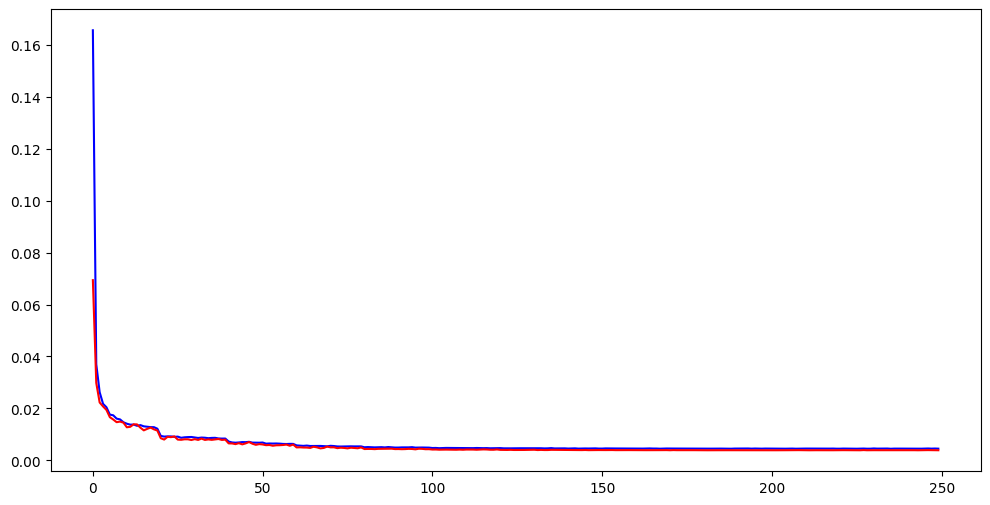

In [61]:
plt.figure(figsize=(12,6))
plt.plot(range(len(hist_train_loss)),hist_train_loss, c='b')
plt.plot(range(len(hist_val_loss)),hist_val_loss, c='r')


In [62]:
def load_checkpoint(model, optimizer=None, scheduler=None, path=None, device='cpu'):
    """
    Loads model, optimizer, and scheduler states from a checkpoint file.

    Parameters:
        model (torch.nn.Module): Model instance to load weights into.
        optimizer (torch.optim.Optimizer, optional): Optimizer instance.
        scheduler (torch.optim.lr_scheduler._LRScheduler, optional): Scheduler instance.
        path (str): Path to the checkpoint file.
        device (str or torch.device): Device to map the checkpoint to.

    Returns:
        model (torch.nn.Module): Model with loaded weights.
        optimizer (torch.optim.Optimizer, optional): Optimizer with loaded state (if provided).
        scheduler (torch.optim.lr_scheduler._LRScheduler, optional): Scheduler with loaded state (if provided).
        start_epoch (int): Epoch to resume training from.
    """
    if path is None:
        raise ValueError("Checkpoint path must be provided.")

    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state'], strict=False)
    
    start_epoch = checkpoint.get('epoch', 0) + 1

    if optimizer and 'optimizer' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer'])

    if scheduler and 'scheduler' in checkpoint:
        scheduler.load_state_dict(checkpoint['scheduler'])

    print(f"Loaded checkpoint from {path}, resuming at epoch {start_epoch}")
    return model, optimizer, scheduler, start_epoch

In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [64]:
model_path = './runs'
runs_list = []
for dirpath, _, filenames in os.walk(model_path):
    for file in sorted(filenames):
            runs_list.append(os.path.join(dirpath, file))
runs_list

['./runs/best_epoch001.pt',
 './runs/best_epoch002.pt',
 './runs/best_epoch003.pt',
 './runs/best_epoch004.pt',
 './runs/best_epoch005.pt',
 './runs/best_epoch006.pt',
 './runs/best_epoch007.pt',
 './runs/best_epoch008.pt',
 './runs/best_epoch010.pt',
 './runs/best_epoch011.pt',
 './runs/best_epoch015.pt',
 './runs/best_epoch016.pt',
 './runs/best_epoch020.pt',
 './runs/best_epoch021.pt',
 './runs/best_epoch022.pt',
 './runs/best_epoch026.pt',
 './runs/best_epoch027.pt',
 './runs/best_epoch030.pt',
 './runs/best_epoch041.pt',
 './runs/best_epoch042.pt',
 './runs/best_epoch043.pt',
 './runs/best_epoch045.pt',
 './runs/best_epoch049.pt',
 './runs/best_epoch052.pt',
 './runs/best_epoch054.pt',
 './runs/best_epoch059.pt',
 './runs/best_epoch061.pt',
 './runs/best_epoch063.pt',
 './runs/best_epoch064.pt',
 './runs/best_epoch065.pt',
 './runs/best_epoch068.pt',
 './runs/best_epoch081.pt',
 './runs/best_epoch084.pt',
 './runs/best_epoch092.pt',
 './runs/best_epoch096.pt',
 './runs/best_epoch1

In [65]:
# Load trained model

TBCNN = TwoBranchCNN()
TBCNN, _, _, _ = load_checkpoint(TBCNN, path=runs_list[-1], device=device )
TBCNN.eval()


size of input layer of FC 39160
Loaded checkpoint from ./runs/best_epoch203.pt, resuming at epoch 204


TwoBranchCNN(
  (hsi_branch): Sequential(
    (0): Conv1d(1, 20, kernel_size=(45,), stride=(1,), padding=(22,))
    (1): ReLU()
    (2): Conv1d(20, 20, kernel_size=(45,), stride=(1,), padding=(22,))
    (3): ReLU()
    (4): Conv1d(20, 20, kernel_size=(45,), stride=(1,), padding=(22,))
    (5): ReLU()
  )
  (msi_branch): Sequential(
    (0): Conv2d(4, 30, kernel_size=(10, 10), stride=(1, 1), padding=(5, 5))
    (1): ReLU()
    (2): Conv2d(30, 30, kernel_size=(10, 10), stride=(1, 1), padding=(5, 5))
    (3): ReLU()
    (4): Conv2d(30, 30, kernel_size=(10, 10), stride=(1, 1), padding=(5, 5))
    (5): ReLU()
  )
  (hsi_flatten): Flatten(start_dim=1, end_dim=-1)
  (msi_flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_layers): Sequential(
    (0): Linear(in_features=39160, out_features=450, bias=True)
    (1): BatchNorm1d(450, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=450, out_features=450, bias=True)
    (4): BatchNorm1d(450,

### FITS Images

In [58]:
from astropy.io import fits

hdu_list = fits.open("/mnt/c/data/AVIRIS/GT/ang20160910t223011_rdn_v1n2_vnir_gt.fits")
hdu_list.info()
hdu_list.close()
image_data = fits.getdata("/mnt/c/data/AVIRIS/GT/ang20160910t223011_rdn_v1n2_vnir_gt.fits")

Filename: /mnt/c/data/AVIRIS/GT/ang20160910t223011_rdn_v1n2_vnir_gt.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       7   (287, 513, 66)   float32   


In [59]:
type(image_data)

numpy.ndarray

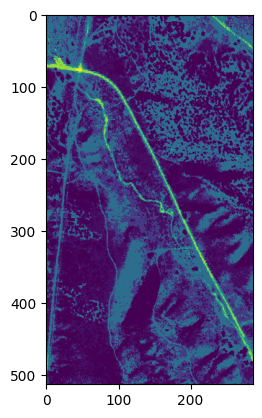

In [61]:
plt.imshow(image_data[0,:,:])

#### Get dataset for tests

In [66]:
def set_seed(seed: int):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [67]:
args = SimpleNamespace(
    image_path='/mnt/c/data/AVIRIS/',
    srf_path="srf/Landsat8_BGRI_SRF.xls",
    image_number=4,
    seed=3407,
    patch_size=31,
    scale=2,
    train_mode=False,
    training_ratio=0.7,
    stride=10
)

In [68]:
# Use Aviris Dataset class and tools
set_seed(args.seed)
dataset = AvirisDataset(args=args, device=device)

Low resolution 15
4
Number of tiles 4
Making test dataset


0it [00:00, ?it/s]

Reading HS data from /mnt/c/data/AVIRIS/f111116t01p00r21/f111116t01p00r21rdn_c/f111116t01p00r21rdn_c_sc01_ort_img
Shape of hyperspectral data: (224, 2955, 1067)
Number of bands: 224
Cropped image shape (1979, 379, 224)
global min and max -21, 22913


4it [00:38,  9.68s/it]

Test dataset built


In [69]:
torch.cuda.empty_cache()

In [70]:
test_hrhsi = dataset.test_GT_list[0]
test_hrmsi = dataset.test_HRMSI_list[0]
test_lrhsi = dataset.test_LRHSI_list[0]

In [71]:
print(len(dataset.test_GT_list))
print(test_hrhsi.shape)
print(test_lrhsi.shape)
print(test_hrmsi.shape)

1
(1979, 379, 224)
(989, 189, 224)
(1979, 379, 4)


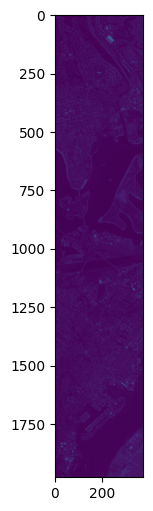

In [72]:
plt.figure(figsize=(15,6))
plt.imshow(test_hrhsi[:,:,15])

False


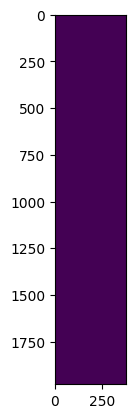

In [73]:
toto = (test_hrhsi[:,:,10] < 0).astype(int)
print((test_hrhsi[:,:,:] < 0).any(axis=None,where=True))
plt.imshow(toto)

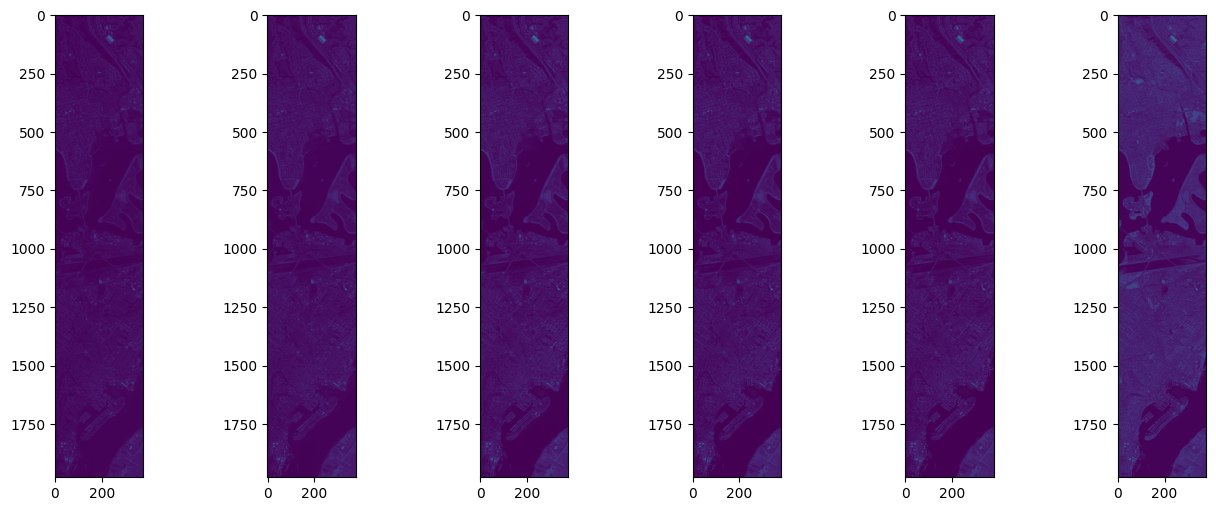

In [74]:
fig, ax = plt.subplots(1,6)
fig.set_size_inches((16,6))
start = 160
step = 5
init = 10
for i in range(1,7):
    curr = start + i
    plt.subplot(start+i)
    plt.imshow(test_hrhsi[:,:,init+step*i])

In [75]:
test_hrmsi.min()

np.float64(0.0027748601805605735)

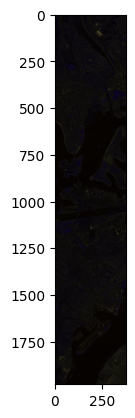

In [81]:
plt.imshow((test_hrmsi[:,:,1:]*255).astype(np.uint8), vmin=0,vmax=255, cmap='Wistia')

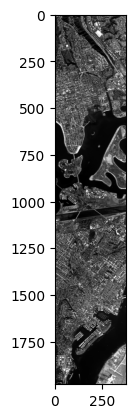

In [163]:
# plt.imshow(test_hrmsi[:,:,0], vmin=0,vmax=1, cmap='gray')
# rgb = np.stack(
#     [test_hrmsi[:, :, 0],
#      test_hrmsi[:, :, 1],
#      test_hrmsi[:, :, 2]],
#     axis=-1
# )
# rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-8)
# plt.imshow(rgb)

band = test_hrmsi[:, :, 1]
p1, p99 = np.percentile(band, [1, 99])
plt.imshow(np.clip((band - p1) / (p99 - p1), 0, 1),
           cmap='gray')

In [48]:
test_hrhsi[:,:,:].sum().item() != 0

True

Predict image

In [76]:
@torch.no_grad()
def predict(model, patch, spectrum, device):
    transposed_patch = np.transpose(patch,(2,0,1))
    tensor_patch = torch.tensor(transposed_patch).to(device, dtype=torch.float)
    tensor_spectrum = torch.tensor(np.reshape(spectrum,(1,len(spectrum)))).to(device, dtype=torch.float)
    model.cuda()
    pred = model(tensor_spectrum.unsqueeze(0), tensor_patch.unsqueeze(0))
    # torch.cuda.empty_cache()
    return pred.detach().cpu().numpy()

In [77]:
def upscale_hyperspectral(img: np.ndarray, target_dims: tuple, method: str = 'bicubic') -> np.ndarray:
    
    assert img.ndim == 3, "Input image must have shape (bands, height, width)"
    assert method in ['bilinear', 'bicubic'], "Method must be 'bilinear' or 'bicubic'"
    
    interp = cv2.INTER_LINEAR if method == 'bilinear' else cv2.INTER_CUBIC
    _, _, bands = img.shape
    H, W = target_dims
    upscaled = np.zeros((H, W, bands), dtype=img.dtype)
    
    for b in range(bands):
        upscaled[:,:,b] = cv2.resize(img[:,:,b], (W,H), interpolation=interp)
    
    return upscaled

In [78]:
# Fonction qui calcule l'image prédite : prendre en entrée MSI/HSI, upscaler HSI, boucler sur i et j, appeler le modèle, prédire le spectre, remplir le cube de sortie
def build_image(model: torch.nn, hsi: np.array, msi: np.array, device: torch.cuda.device) -> np.array:
    """ 
    msi : H,W,c
    hsi: h,w,C
    """
    H, W = msi.shape[:2]
    C = hsi.shape[2]
    print("hsi shape",hsi.shape)
    hrhsi = np.zeros((H,W,C))
    upscaled_hsi = upscale_hyperspectral(hsi,(H,W), method='bicubic')
    print("upscaled hsi",upscaled_hsi.shape)
    offset = int((model.patch_size - 1)/2)
    print(offset)
    for i in tqdm(range(offset, H - offset)):
        for j in range(offset, W - offset):
            current_patch_msi = msi[i-offset:i+offset+1,j-offset:j+offset+1,:]
            # print("current patch", current_patch_msi)
            current_spectrum_hsi = upscaled_hsi[i,j,:]
            # print("current spectrum",current_spectrum_hsi)
            hrhsi[i,j,:] = predict(model, current_patch_msi,current_spectrum_hsi,device)
            # print(f"hrshi {hrhsi[i,j,:]}")
        #     if j>=2:
        #         break
        # break
    return hrhsi 

In [79]:
pred_hrhsi = build_image(TBCNN,test_lrhsi,test_hrmsi,device)

hsi shape (989, 189, 224)
upscaled hsi (1979, 379, 224)
15


100%|██████████| 1949/1949 [23:54<00:00,  1.36it/s]


(1979, 379, 224)


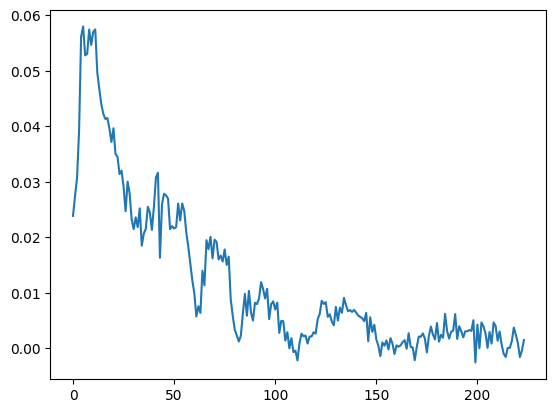

In [82]:
print(pred_hrhsi.shape)
plt.plot(pred_hrhsi[15,17,:])

Comparison test and prediction

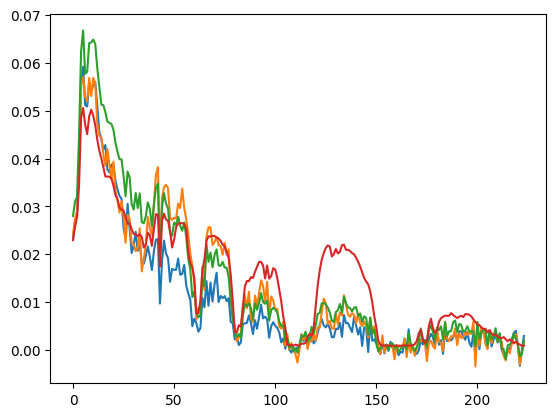

In [94]:
plt.plot(pred_hrhsi[1000,100,:])
plt.plot(pred_hrhsi[121,101,:])
plt.plot(pred_hrhsi[300,350,:])
plt.plot(test_hrhsi[250,50,:])

In [85]:
test_hrhsi.shape
pred_hrhsi.shape

(1979, 379, 224)

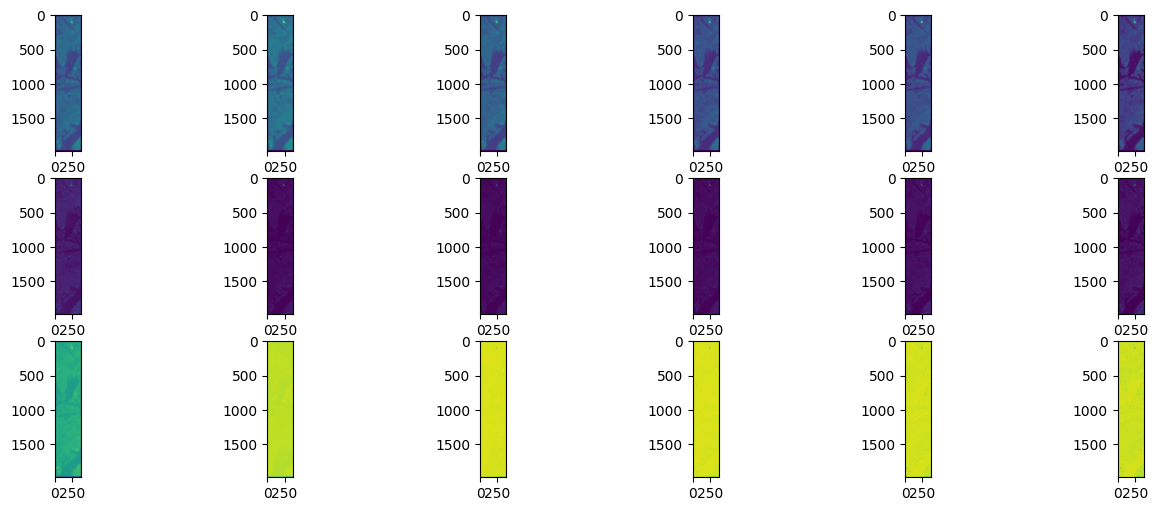

In [89]:
fig, ax = plt.subplots(3,6)
fig.set_size_inches((16,6))
step = 5
init = 0
for i in range(6):
    ax[0,i].imshow(pred_hrhsi[:,:,init+step*i])
    ax[1,i].imshow(test_hrhsi[:,:,init+step*i])
    ax[2,i].imshow(pred_hrhsi[:,:,init+step*i] - test_hrhsi[:,:,init+step*i])

Compute metrics

In [95]:
from utils import Metric

test_metric = Metric()

In [96]:
# Save rebuilt image
with open("pred_hrhsi.pkl", "wb") as f:
    pickle.dump(pred_hrhsi, f)

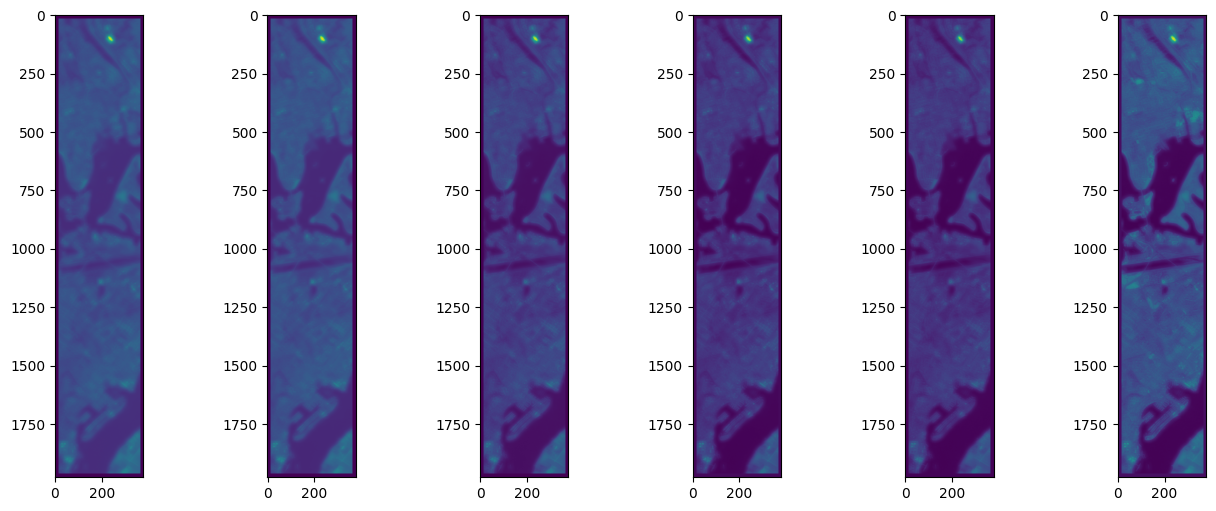

In [97]:
fig, ax = plt.subplots(1,6)
fig.set_size_inches((16,6))
start = 160
step = 5
for i in range(1,7):
    curr = start + i
    plt.subplot(start+i)
    plt.imshow(pred_hrhsi[:,:,10+step*i])

array([-6.34732842e-03, -6.28691912e-03, -4.76014614e-03, -8.28003883e-03,
       -1.27162896e-02, -1.21511817e-02, -1.30010843e-02, -1.18103623e-02,
       -1.23423934e-02, -1.52436495e-02, -1.41801238e-02, -1.31016374e-02,
       -1.32227540e-02, -1.38872266e-02, -1.25713348e-02, -1.28646344e-02,
       -1.11028105e-02, -1.18033327e-02, -1.43330097e-02, -1.56536996e-02,
       -1.25238895e-02, -1.16750598e-02, -1.22112036e-02, -1.29395127e-02,
       -1.36293471e-02, -1.37623549e-02, -1.49767101e-02, -1.51212215e-02,
       -1.44026577e-02, -1.28288567e-02, -1.58159137e-02, -1.45202428e-02,
       -1.23144388e-02, -1.51117593e-02, -1.39784291e-02, -1.16946995e-02,
       -1.28439963e-02, -1.41151547e-02, -1.38671994e-02, -1.37767643e-02,
       -1.51260495e-02, -1.90340281e-02, -1.75352693e-02, -1.00199580e-02,
       -1.70255601e-02, -1.63813382e-02, -1.52377188e-02, -1.55631900e-02,
       -1.36895180e-02, -1.20402277e-02, -1.49502158e-02, -1.42155290e-02,
       -1.51446462e-02, -

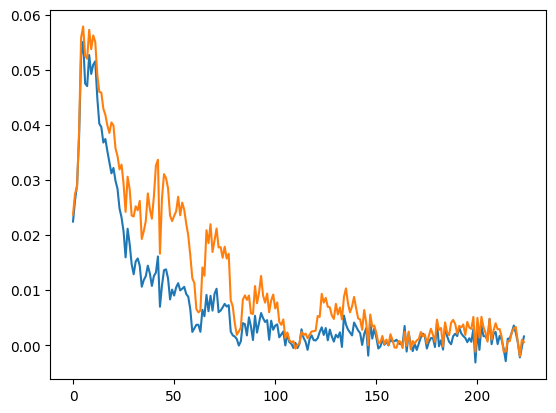

In [98]:
plt.plot(pred_hrhsi[500,300,:])
plt.plot(pred_hrhsi[250,300,:])
pred_hrhsi[500,300,:] - pred_hrhsi[200,300,:]

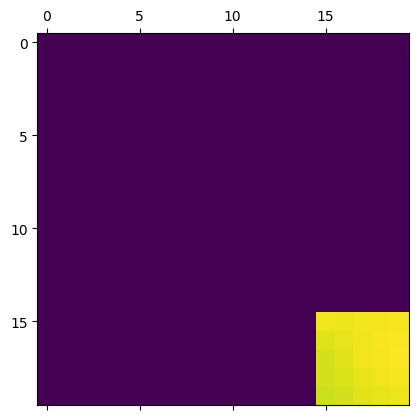

In [101]:
plt.matshow(pred_hrhsi[:20,:20,5])

In [104]:
type(test_hrhsi)

numpy.ndarray

In [102]:
# Exclude non predicted areas
H, W , _ = test_hrhsi.shape
test_hrhsi_cropped = test_hrhsi[15:H-15,15:W-15,:]
pred_hrhsi_cropped = pred_hrhsi[15:H-15,15:W-15,:]
print(test_hrhsi_cropped.shape, pred_hrhsi_cropped.shape)

(1949, 349, 224) (1949, 349, 224)


Check training input

In [105]:
metrics = Metric(test_hrhsi_cropped,pred_hrhsi_cropped)

In [107]:
metrics.get_metrics()

{'PSNR': np.float64(36.93860719585067),
 'RMSE': np.float64(0.014225568793912307),
 'SAM': np.float64(17.589609542872875),
 'ERGAS': np.float64(20.116347039742323),
 'SSIM': np.float64(0.8444614350545058)}

Débeugage (OBSOLETE)

In [107]:
# Vérifier que les spectres de lrhsi ne sont pas constants
with open('./dataset/dataset_training_10.pkl', "rb") as f:
    training_GT_list, training_LRHSI_list, training_HSMSI_list = pickle.load(f)

In [112]:
len(training_LRHSI_list)

38835

In [110]:
training_LRHSI_list[0].shape

(224,)

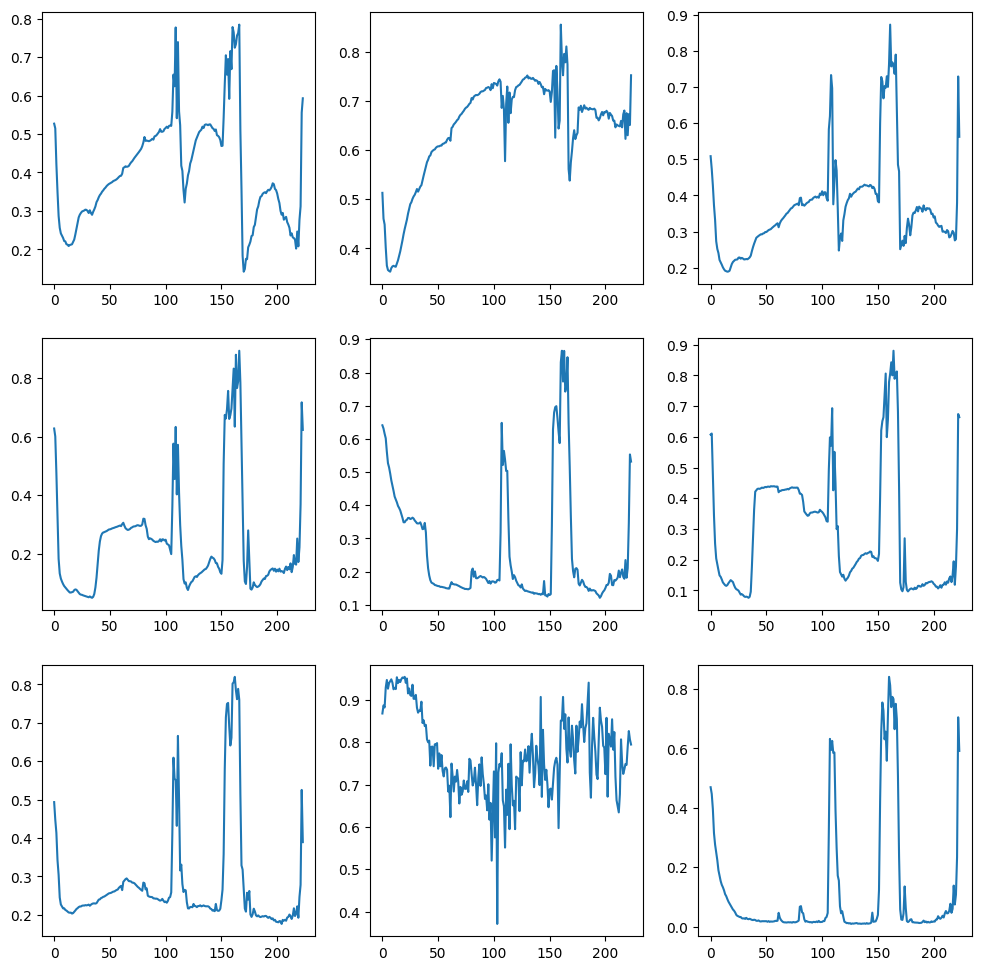

In [114]:
# plot random spectra
import random as rnd
range_i = len(training_LRHSI_list)
plot_number = 9
fig, ax = plt.subplots(3,3)
fig.set_size_inches((12,12))
for i in range(plot_number):
    plt.subplot(330+i+1)
    picked_i = rnd.randint(0,range_i)
    plt.plot(training_LRHSI_list[picked_i])


### Crop maximum valid rectangle from images

In [51]:
with rasterio.open('/mnt/c/data/AVIRIS/f111116t01p00r19/f111116t01p00r19rdn_c/f111116t01p00r19rdn_c_sc01_ort_img') as src:
    hyperspectral_data = src.read()

In [52]:
hyperspectral_data = rearrange(hyperspectral_data,'c h w -> h w c')

In [53]:
hyperspectral_data.shape

(2799, 1076, 224)

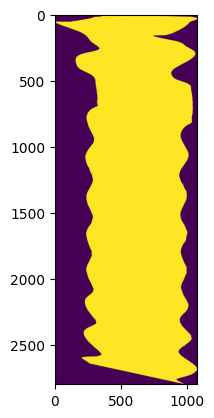

In [54]:
mask = np.all(hyperspectral_data != -50, axis=2).astype(np.uint8)
plt.imshow(mask)

In [83]:
def max_inner_rectangle(hsi_image: np.ndarray, invalid_value: float = -50):
    """
    Extract the largest inner rectangle with no unobserved pixels from a hyperspectral image.
    
    Args:
        hsi_image (np.ndarray): Hyperspectral image (H, W, C)
        invalid_value (float): Value indicating unobserved pixels
        
    Returns:
        tuple: (x, y, w, h) of the largest valid rectangle
    """
    # Use the first band to detect unobserved pixels (or min across bands)
    mask = np.all(hsi_image != invalid_value, axis=2).astype(np.uint8)
    
    # Convert binary mask to a form suitable for the algorithm
    height, width = mask.shape
    max_area = 0
    max_rect = (0, 0, 0, 0)
    hist = np.zeros(width, dtype=int)

    for i in range(height):
        for j in range(width):
            hist[j] = hist[j] + 1 if mask[i, j] == 1 else 0
        # Use histogram to find largest rectangle in this row
        stack = []
        j = 0
        while j <= width:
            h = hist[j] if j < width else 0
            if not stack or h >= hist[stack[-1]]:
                stack.append(j)
                j += 1
            else:
                top = stack.pop()
                w = j if not stack else j - stack[-1] - 1
                area = hist[top] * w
                if area > max_area:
                    max_area = area
                    x = stack[-1] + 1 if stack else 0
                    y = i - hist[top] + 1
                    max_rect = (x, y.item(), w, hist[top].item())
    return max_rect


In [38]:
A = np.array([[0,0,0],[1,1,0],[1,1,0],[1,1,0]]).reshape((4,3,1))
A.shape

(4, 3, 1)

In [84]:
max_inner_rectangle(A,0)

(0, 1, 2, 3)

In [85]:
# x, y, w, h = get_max_inner_rectangle(hyperspectral_data,-50)
x, y, w, h = max_inner_rectangle(test_hrhsi,0)

In [34]:
x,y,w,h

(310, np.int64(2378), 4, np.int64(1))

In [31]:
# cropped_hsi = hyperspectral_data[y:y+h, x:x+w, :]
cropped_hsi = test_hrhsi[y:y+h, x:x+w, :]

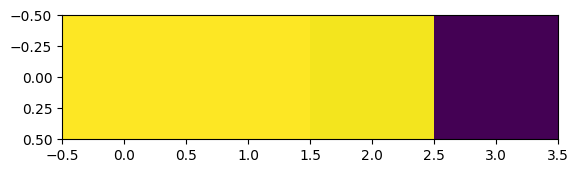

In [32]:
plt.imshow(cropped_hsi[:,:,10])

In [ ]:
def max_safe_rectangle(img: np.ndarray, forbidden_value: float):
    h, w, c = img.shape

    # Create a binary map: True if the pixel is safe (not all channels == forbidden_value)
    safe_mask = ~(np.isclose(img, forbidden_value).all(axis=2))

    # Initialize heights array for histogram method
    heights = np.zeros((h, w), dtype=int)

    for i in range(h):
        for j in range(w):
            if safe_mask[i, j]:
                heights[i, j] = heights[i - 1, j] + 1 if i > 0 else 1
            else:
                heights[i, j] = 0

    max_area = 0
    result = (0, 0, 0, 0)  # x, y, width, height

    # For each row, apply largest histogram rectangle logic
    for i in range(h):
        stack = []
        row = heights[i]
        row_with_zero = np.concatenate((row, [0]))  # Append a 0 to handle remaining elements in stack
        for idx in range(len(row_with_zero)):
            while stack and row_with_zero[stack[-1]] > row_with_zero[idx]:
                height = row_with_zero[stack.pop()]
                left = stack[-1] if stack else -1
                width = idx - left - 1
                area = height * width
                if area > max_area:
                    max_area = area
                    x = left + 1
                    y = i - height + 1
                    w_rect = width
                    h_rect = height
                    result = (x, y.item(), w_rect, h_rect.item())
            stack.append(idx)

    return result

In [58]:
A_2D = A.squeeze(axis=2)
max_safe_rectangle(A,0)

(0, 1, 2, 3)

In [73]:
x, y, w, h = max_safe_rectangle(hyperspectral_data,-50)

In [75]:
x, y, w, h = get_max_inner_rectangle(hyperspectral_data,-50)

In [76]:
x, y, w, h

(351, 197, 524, 2467)

In [77]:
cropped_hsi = hyperspectral_data[y:y+h,x:x+w,:]

In [79]:
cropped_hsi.shape

(2467, 524, 224)

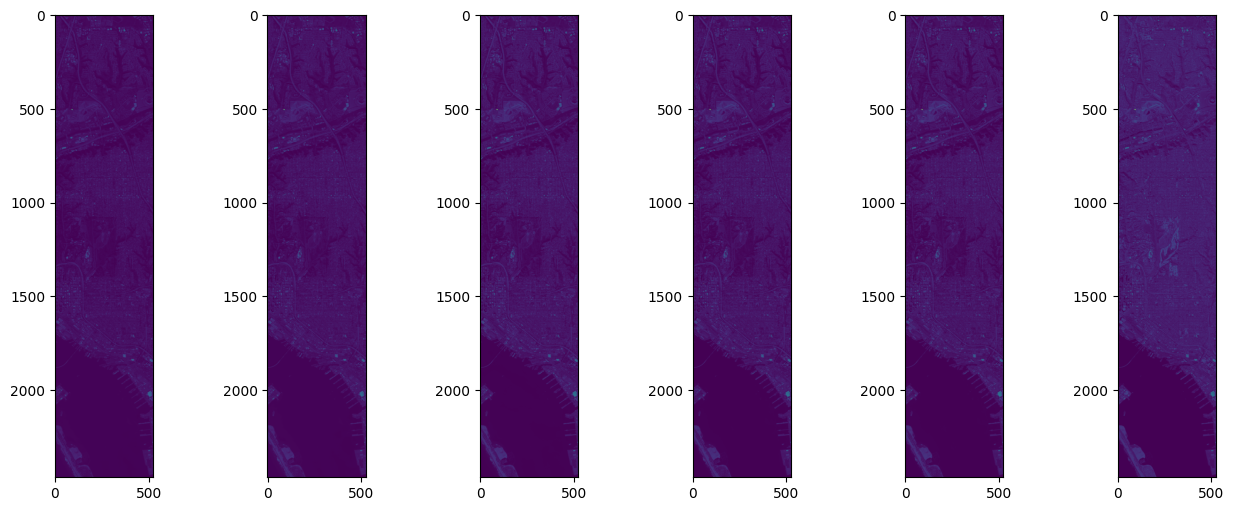

In [78]:
fig, ax = plt.subplots(1,6)
fig.set_size_inches((16,6))
start = 160
step = 5
init = 10
for i in range(1,7):
    plt.subplot(start+i)
    plt.imshow(cropped_hsi[:,:,init+step*i])

In [82]:
cropped_hsi[2466,0,init]

np.int16(1060)

Tests average vs prediction

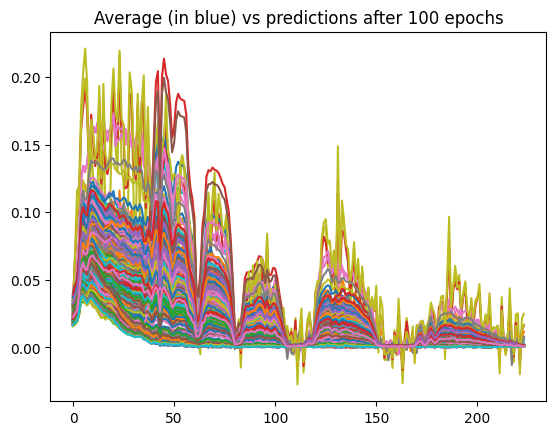

In [32]:
with open("DEBUG_average_pred.pkl","rb") as f:
    avg, pred = pickle.load(f)
    plt.plot(avg.squeeze(), label='train mean')
    for i in range(len(pred)):
        plt.plot(pred[i,:], label='model output')
    plt.title("Average (in blue) vs predictions after 100 epochs")


In [26]:
pred.squeeze().shape

(128, 224)